# Pits, SMP, and SSA Oh My 

The notebook attempts to use the database to find all the SMP profiles associated with Pits where SSA was also measured 

In [1]:
# Import the function to get connect to the db
from snowexsql.db import get_db
from snowexsql.data import LayerData
from snowexsql.conversions import query_to_pandas, query_to_geopandas
from datetime import date 

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name, credentials=None)

In [2]:
# Grab the unique site ids and dates where SMP was used
qry = session.query(LayerData.site_id, LayerData.date).filter(LayerData.type=='force').distinct()
results = qry.all()

# Clean the site ids up and make data into a list 
smp_sites = [r[0].split('_')[0].replace('COGM','') for r in results]
smp_dates = [r[1] for r in results]

print(smp_sites)
print(smp_dates)

['3S14', '3S33', '2C12', '3N22', '2N13', '1N23', '2S11', '3S5', '5S21', '7C15', '1N3', '3S47', '2S48', '9N29', 'GML', '2S7', '1S2', '2N14', '3S38', '5N15', '5N19', '6N17', '2N4', '9S51', '1S1', '6S34', '9C17', '1S8', '5S43', '2S16', '8C18', '1S17', 'TLS-FL2A', '8N38', '2N12', '5S29', '9C16', '8N25', '5N11', '2N51', '8C11', '6N18', '5C21', '1N6', '2S3', 'TLS-FL3A', '5N10', '5N10']
[datetime.date(2020, 2, 1), datetime.date(2020, 2, 4), datetime.date(2020, 2, 12), datetime.date(2020, 1, 28), datetime.date(2020, 2, 6), datetime.date(2020, 2, 11), datetime.date(2020, 2, 1), datetime.date(2020, 1, 29), datetime.date(2020, 2, 1), datetime.date(2020, 1, 30), datetime.date(2020, 2, 11), datetime.date(2020, 1, 29), datetime.date(2020, 1, 29), datetime.date(2020, 1, 30), datetime.date(2020, 2, 2), datetime.date(2020, 2, 8), datetime.date(2020, 2, 8), datetime.date(2020, 2, 11), datetime.date(2020, 2, 4), datetime.date(2020, 2, 6), datetime.date(2020, 1, 28), datetime.date(2020, 2, 10), datetime.d

<AxesSubplot:>

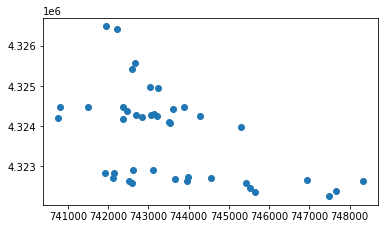

In [3]:
# Grab the Site_id and dates and geom where the data is ssa 
qry = session.query(LayerData.site_id,  LayerData.date, LayerData.geom).filter(LayerData.type == 'specific_surface_area')

# Also contains the same site_id as the smp
qry = qry.filter(LayerData.site_id.in_(smp_sites))

# Also has the same dates as the smp
qry = qry.filter(LayerData.date.in_(smp_dates))

# Grab only the unique
qry = qry.distinct()

# Build a dataframe
df = query_to_geopandas(qry, engine)
df.plot()

In [4]:
session.close()